# **Use CycleGAN to Generate Nighttime Images from Daytime Images**

### Scenario
The team is developing new software around automated detection of cars and pedestrians in all conditions for autonomous drive. One major bottleneck is data collection under severe weather conditions, especially capturing nighttime images. So we need to generate nighttime equivalent images from daytime images, such that you have access to some outdoor images acquired at night and some at day, but no pairwise images are available. Pairwise image means the same view available in day and night times.


We'll implement CycleGAN using Keras with the intention to transform daytime to nighttime images for autonomous drive like in:
https://github.com/simontomaskarlsson/CycleGAN-Keras

This work is an adaptation of the blog in: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

## Lets start with the concepts of CycleGAN:

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B). Here we will consider **Domain-A: Daytime** and **Domain-B: Nighttime**.

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B

Each generator has a corresponding discriminator model.

The first discriminator model (Discriminator-A) takes real images from Domain-A (daytime images) and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B (nighttime images) and generated images from Generator-B and predicts whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models.

The generators learn to better fool the discriminators and the discriminators learn to better detect fake images. Together, the models find an equilibrium during the training process.

Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A


**Our goal is to train such a 2 set Generator-Discriminator pair, to finally generate nighttime images from daytime ones and quantify performance.**



# Install libraries and load data

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 5.7MB/s eta 0:00:01
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
os.chdir('/content/drive/MyDrive/fourthbrain/week_9/live_coding/training/')
!ls

day			      generator_model_plot.png			 night
discriminator_model_plot.png  MLE_Perception_Engineer_Uber_v1_cpm.ipynb


## Design functions for Generator-Discriminator pairs: 

Step 1: Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     131200    
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 128)     256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 256)     524544

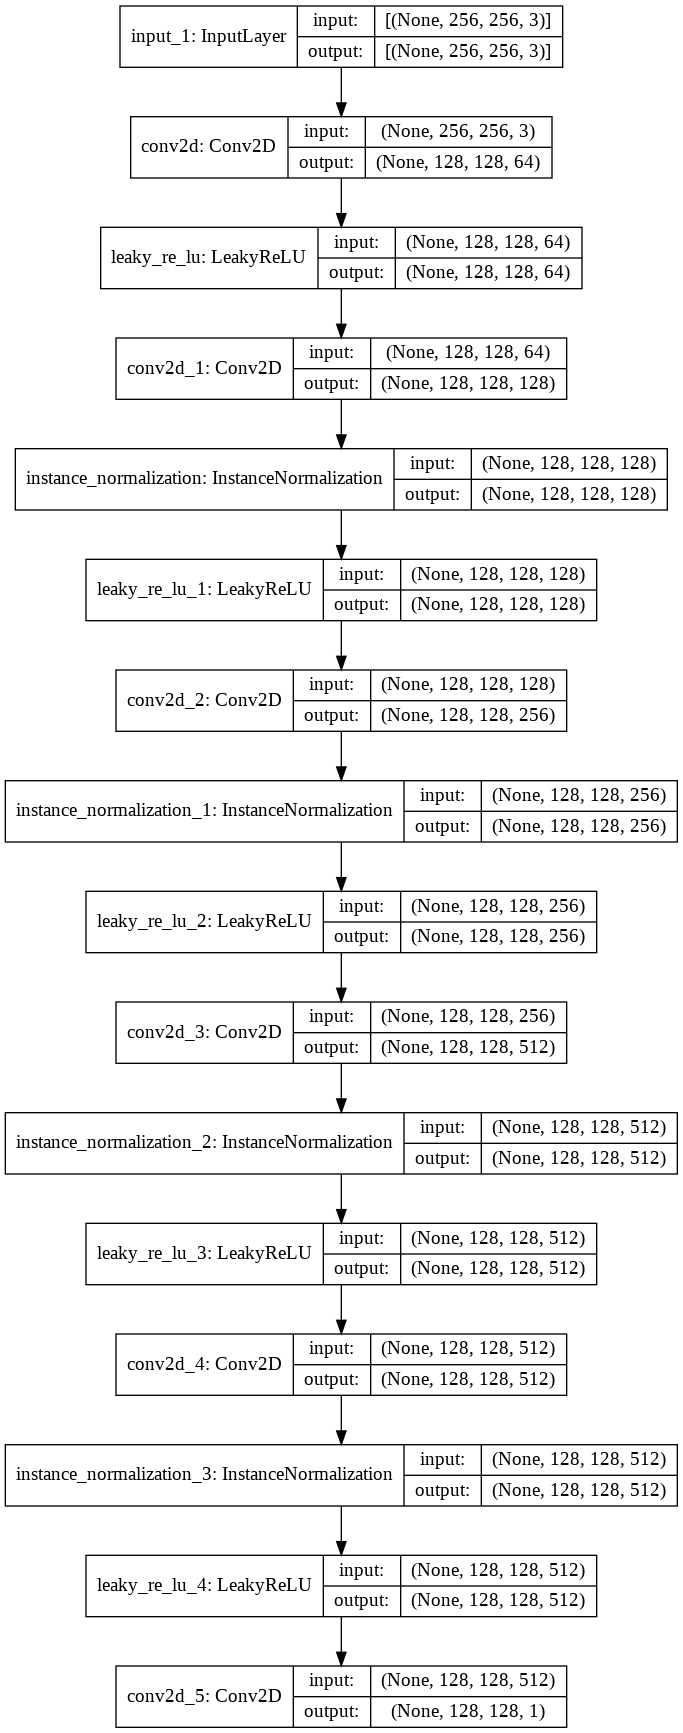

In [5]:
#Step 1: Defining a PatchgGAN discriminator model
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d) #Stride reduces shape of image
	# C128
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

# Note the final shape of the image patch=Patch size

In [6]:
# Step 2: Generator Model
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization()(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [7]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
    # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # R256
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  out_image = Activation('sigmoid')(g)
  # define model
  model = Model(in_image, out_image)
  return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

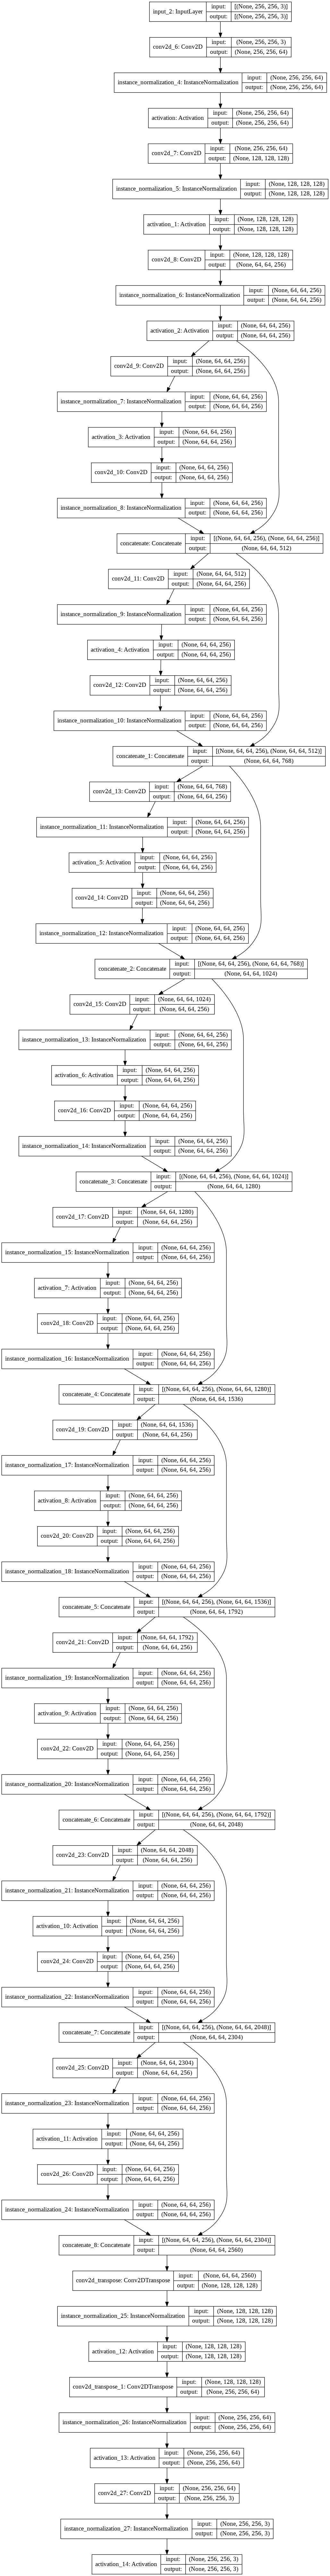

In [8]:
# create the model
model = define_generator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
# Step 3: Define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model
  # Notice no cross entropy loss used here

In [10]:
#Step 4: All definitions together
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [11]:
#Step 5: Helper functions to select real samples and generate fake samples

from random import randint
# function to generate 'n_samples' random integers in range (start,stop)
def randnums(start,stop,n_samples):
  ix=[]
  for i in range(n_samples):
    ix.append(randint(start,stop))
  ix=np.array(ix)
  return ix

In [12]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
# choose random instances
  ix = randnums(0, dataset.shape[0]-1, n_samples)
  # retrieve selected imset))
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  retrn X, y


In [13]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
# update image pool for fake images
import random
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
    # stock the pool
      pool.append(image)
      selected.append(image)
    elif random.random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = randint(0, len(pool)-1)
      print(ix,np.shape(pool))
      selected.append(pool[ix])
      pool[ix] = image
  return np.asarray(selected)


# All helper functions are now defined, now lets begin training!

Order of tasks:
* Update Generator-B (A->B)
* Update Discriminator-B
* Update Generator-A (B->A)
* Update Discriminator-A

In [70]:
# train function for the cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):

  # define properties of the training run
  n_epochs, n_batch, = 8, 1 #Keep n_batch as 1 for per image training. n_epochs can be changed
  # determine the output square shape of the discriminator
  n_patch = d_model_A.output_shape[1] #Notice n_patch depends on the discriminator output image size. This parameter can be changed for improvement.
  
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  print(n_steps)
  for i in range(n_steps):
  # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
  return(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA)

# Train the model from scratch 
## Load the images DomainA-> Day, DomainB-> Night. 
You may use as many as 50 images to train the generator. More images will need more epochs and more train time. So limit training images to 30-50 images from each domain.
# Call the train function to train on the images


In [71]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
import cv2
import glob

In [72]:
# load a daytime images as trainA, nighttime images as train B (numpy lists)
'''
Steps:
1. Randomly sample indices using helper function randnums(start,stop,n_samples)
2. From day and night folders, pull out n images
3. Resize each image using opencv, then append to list/numpy array
'''
# both day and night have the same number of images the same (120)
num_day_images = len(glob.glob('./day/*.jpg'))

# path to images to loop through with my random indices
day_images = glob.glob('./day/*.jpg')
night_images = glob.glob('./night/*.jpg')
IMAGE_SIZE = 256

def load_images(image_paths, sample_n_images=50):
  formatted_images = []
  indices = randnums(0, num_day_images - 1, sample_n_images)
  for i in indices:
    input_image = cv2.imread(image_paths[i])
    # rescale images
    input_image = np.true_divide(input_image, 255)
    # resize  
    resized_image = cv2.resize(input_image, (IMAGE_SIZE, IMAGE_SIZE))
    formatted_images.append(resized_image)
  return np.array(formatted_images)

trainA = load_images(day_images)
trainB = load_images(night_images)

# Next train the cycleGAN using the train function!

In [73]:

[g_day2night, g_night2day, c_day2night, c_night2day] = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, train###

400
>1, dA[0.120,0.226] dB[0.061,0.032] g[8.267,5.915]
>2, dA[0.225,0.217] dB[0.044,0.041] g[7.440,5.846]
>3, dA[0.504,0.364] dB[0.052,0.023] g[8.226,6.827]
>4, dA[0.223,0.197] dB[0.247,0.126] g[3.663,3.230]
>5, dA[0.238,0.173] dB[0.042,0.061] g[4.583,4.151]
>6, dA[0.183,0.162] dB[0.037,0.046] g[5.337,4.753]
>7, dA[0.147,0.167] dB[0.023,0.022] g[5.811,4.805]
>8, dA[0.162,0.200] dB[0.039,0.028] g[8.009,6.323]
>9, dA[0.129,0.119] dB[0.142,0.087] g[4.590,3.814]
>10, dA[0.170,0.160] dB[0.026,0.064] g[7.602,6.230]
>11, dA[0.206,0.162] dB[0.024,0.044] g[8.432,6.446]
>12, dA[0.222,0.180] dB[0.283,0.146] g[3.628,2.920]
>13, dA[0.182,0.149] dB[0.057,0.161] g[3.298,3.488]
>14, dA[0.233,0.209] dB[0.019,0.047] g[7.155,6.667]
>15, dA[0.168,0.168] dB[0.250,0.071] g[4.135,3.532]
>16, dA[0.160,0.176] dB[0.010,0.064] g[6.101,4.925]
>17, dA[0.188,0.162] dB[0.184,0.075] g[3.399,2.693]
>18, dA[0.180,0.153] dB[0.105,0.121] g[3.655,3.695]
>19, dA[0.186,0.164] dB[0.230,0.164] g[3.903,3.583]
>20, dA[0.174,0.1

# Write a test function to generate fake images for the test set
### Create Day->Night, Night->Day. versions separately
### Visualize some images. What parameters would you change to improve?

In [74]:
#Define a test function to generate day to night images
import matplotlib.pyplot as plt
def test(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB):
  # define properties of the training run
  n_epochs, n_batch, = 1, 1 
  # determine the output square shape of the discriminator
  n_patch = 64 #64
  n_steps = 3
  for i in range(n_steps):
    # select a batch of real samples
    X_realA, _ = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, _ = generate_real_samples(trainB, n_batch, n_patch)

    # generate fake sample batch
    X_fakeA, _ = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, _ = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

    # Plot
    # First day to night transformation
    print('Original day image:\n')
    plt.imshow(np.squeeze(X_realA))
    plt.show()
    
    print('Fake night image:\n')
    plt.imshow(np.squeeze(X_fakeB))
    plt.show()
    
    # Next night to day transformation
    print('Original night image:\n')
    plt.imshow(np.squeeze(X_realB))
    plt.show()

    print('Fake day image:\n')
    plt.imshow(np.squeeze(X_fakeA))
    plt.show()


Original day image:



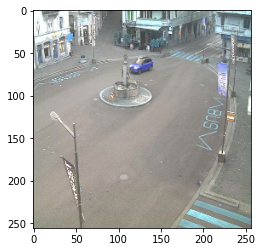

Fake night image:



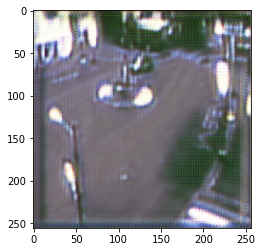

Original night image:



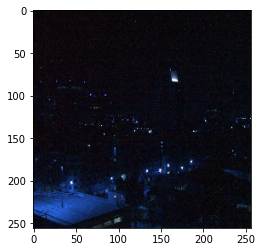

Fake day image:



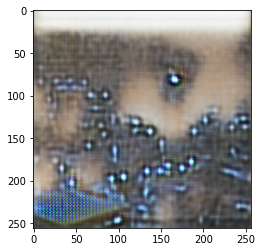

Original day image:



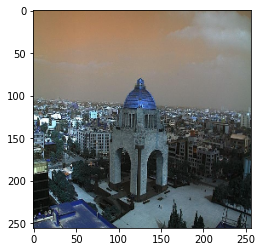

Fake night image:



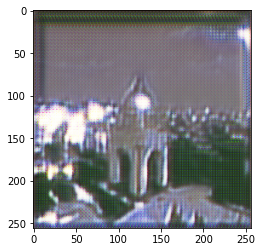

Original night image:



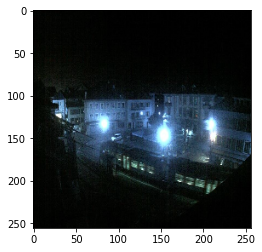

Fake day image:



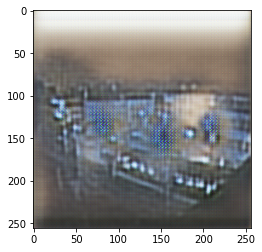

Original day image:



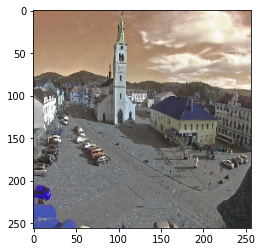

Fake night image:



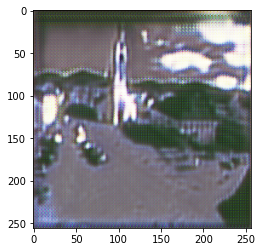

Original night image:



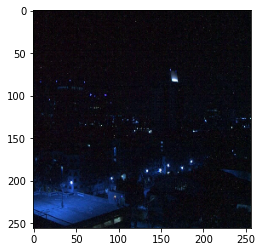

Fake day image:



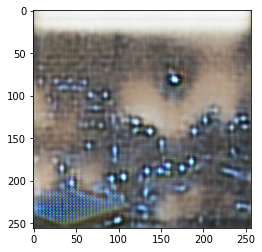

In [75]:
test(g_day2night, g_night2day, c_day2night, c_night2day, trainA, trainB)

 # Notice the banding around edges for the nighttime images. What parameter would you change to reduce this banding?

# Write a function to generate a full cycle Day->night->Day

# Write a function to quantify the error and similarity between the cycle generated image and original image (Day vs Generated Day)

In [36]:
from skimage.metrics import structural_similarity as ssim 
from skimage.metrics import mean_squared_error
def similarity_real_fake(real, fake):
  """Compute similarity in cycle images."""
  mse_cycle = mean_squared_error(real, fake)
  ssim_cycle = ssim(real, fake, multichannel=True, gaussian_weights=True)
  print(f'MSE={mse_cycle:.3f}, SSIM={ssim_cycle:.3f}\n')
  return ssim_cycle

In [87]:
def test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):
  """Generate cycle and compare structural similarity between orig image and cycle image."""  
  # properties of training run
  n_batch = 1

  # determine the output square shape of discriminator
  n_patch = 16

  # keep track of ssim scores for day and night 
  day_scores = []
  night_scores = []

  n_steps = 10
  for i in range(n_steps):
    # real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    
    # generate fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

    # cycle from fake to fake for cycle consistency testing
    X_fakeAA, y_fakeAA = generate_fake_samples(g_model_BtoA, X_fakeB, n_patch)
    X_fakeBB, y_fakeBB = generate_fake_samples(g_model_AtoB, X_fakeA, n_patch)

    # Plot
    # Day to day cycle
    real_A = np.squeeze(X_realA) 
    fake_cycle_A = np.squeeze(X_fakeAA)
    print('Original day image:\n')
    plt.imshow(real_A)
    plt.show()
    
    print('Fake day image after cycle:\n')
    plt.imshow(fake_cycle_A)
    plt.show()
    
    day_ssim_cycle_score = similarity_real_fake(real_A, fake_cycle_A)

    # Night to night cycle
    real_B = np.squeeze(X_realB) 
    fake_cycle_B = np.squeeze(X_fakeBB)
    print('Original night image:\n')
    plt.imshow(real_B)
    plt.show()

    print('Fake night image after cycle:\n')
    plt.imshow(fake_cycle_B)
    plt.show()

    night_ssim_cycle_score = similarity_real_fake(real_B, fake_cycle_B)

    day_scores.append(day_ssim_cycle_score)
    night_scores.append(night_ssim_cycle_score)

  print(f'Mean SSIM day score: {np.mean(day_scores):.2f}')
  print(f'Mean SSIM night score: {np.mean(night_scores):.2f}')

Original day image:



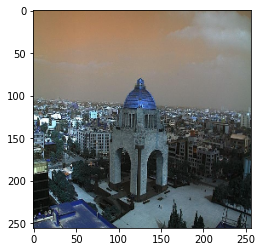

Fake day image after cycle:



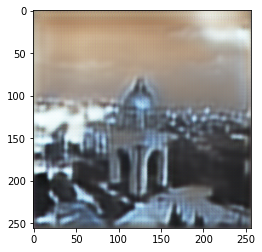

MSE=0.026, SSIM=0.680

Original night image:



/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


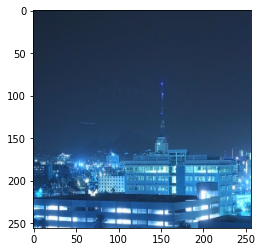

Fake night image after cycle:



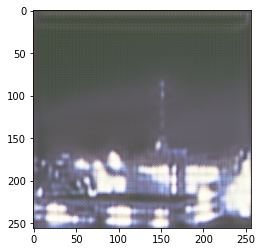

MSE=0.038, SSIM=0.677

Original day image:



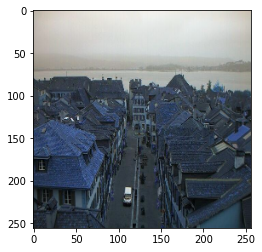

Fake day image after cycle:



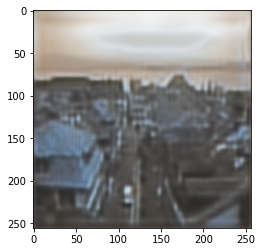

MSE=0.013, SSIM=0.709

Original night image:



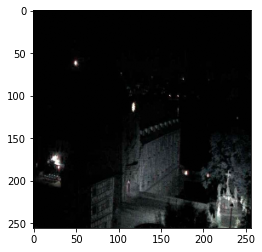

Fake night image after cycle:



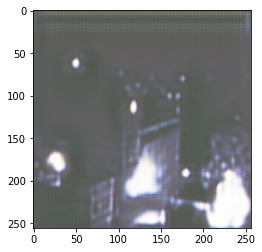

MSE=0.153, SSIM=0.107

Original day image:



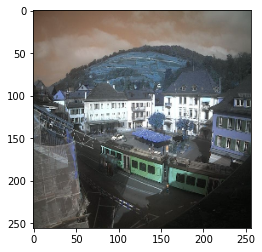

Fake day image after cycle:



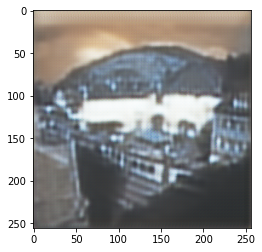

MSE=0.024, SSIM=0.642

Original night image:



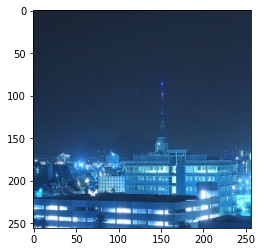

Fake night image after cycle:



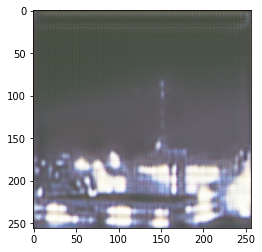

MSE=0.040, SSIM=0.664

Original day image:



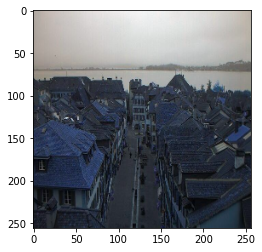

Fake day image after cycle:



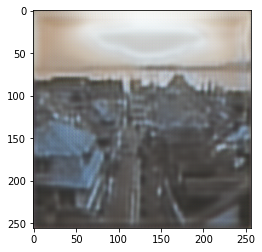

MSE=0.021, SSIM=0.694

Original night image:



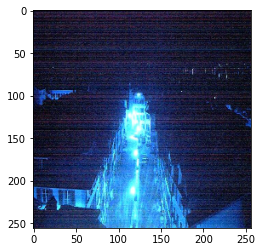

Fake night image after cycle:



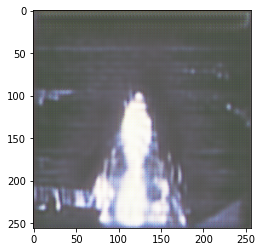

MSE=0.061, SSIM=0.400

Original day image:



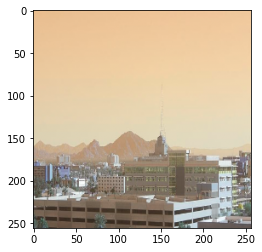

Fake day image after cycle:



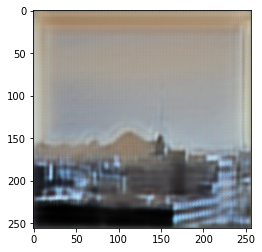

MSE=0.039, SSIM=0.768

Original night image:



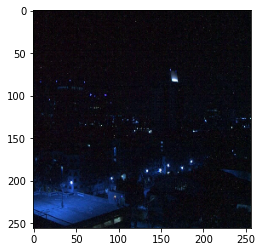

Fake night image after cycle:



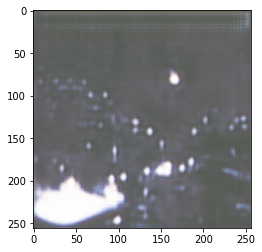

MSE=0.144, SSIM=0.219

Original day image:



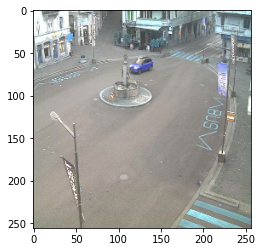

Fake day image after cycle:



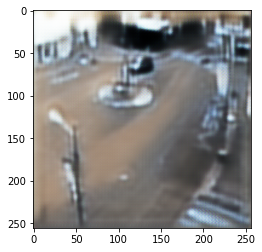

MSE=0.026, SSIM=0.702

Original night image:



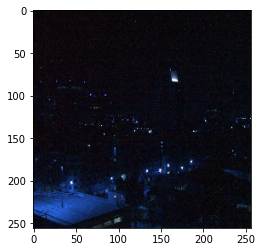

Fake night image after cycle:



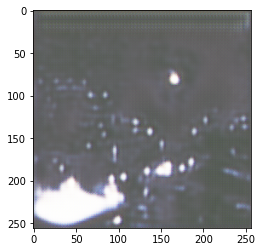

MSE=0.144, SSIM=0.220

Original day image:



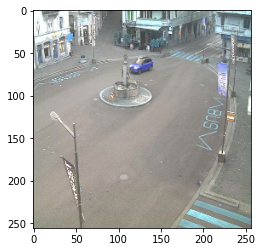

Fake day image after cycle:



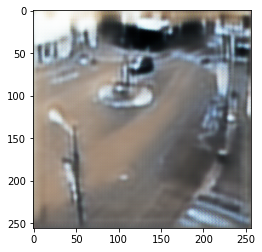

MSE=0.026, SSIM=0.702

Original night image:



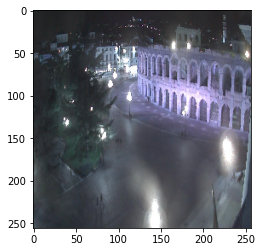

Fake night image after cycle:



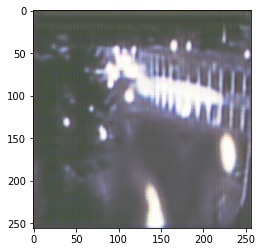

MSE=0.016, SSIM=0.737

Original day image:



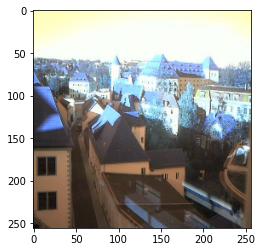

Fake day image after cycle:



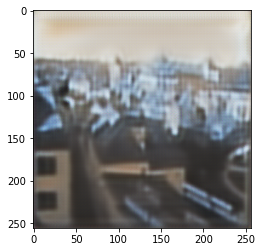

MSE=0.018, SSIM=0.745

Original night image:



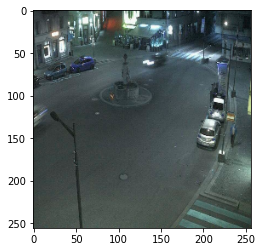

Fake night image after cycle:



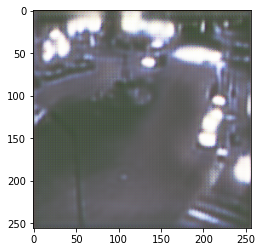

MSE=0.030, SSIM=0.704

Original day image:



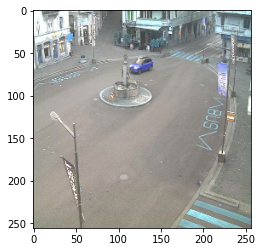

Fake day image after cycle:



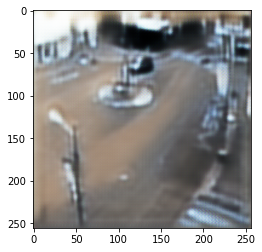

MSE=0.026, SSIM=0.702

Original night image:



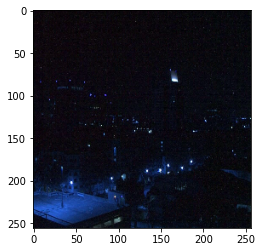

Fake night image after cycle:



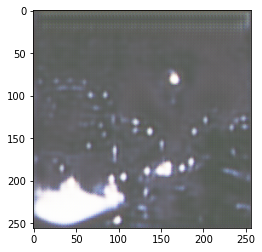

MSE=0.145, SSIM=0.218

Original day image:



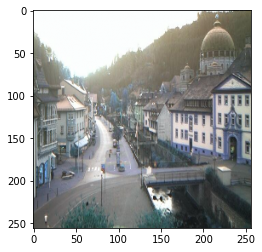

Fake day image after cycle:



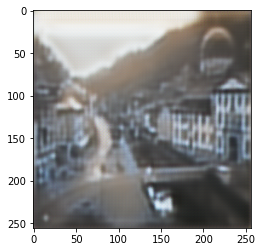

MSE=0.010, SSIM=0.759

Original night image:



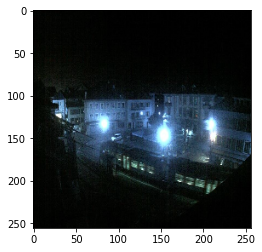

Fake night image after cycle:



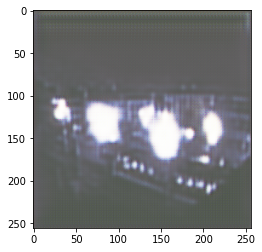

MSE=0.113, SSIM=0.221

Mean SSIM day score: 0.71
Mean SSIM night score: 0.42


In [89]:
test_Cycle(g_day2night, g_night2day, c_day2night, c_night2day, trainA,trainB)

# Which domain transformation is better quality? What are some steps to improve performance?

- The cycle consistency from day to night to day (DND) is much better quality than night to day to night (NDN) as measured by the structural similarity index (SSIM). 
  - DND had SSIM scores of ~0.70, while NDN typically was around 0.35. 
- I looked at varying the n_patch variable with sizes {16, 32, 64, 128}. 
  - Across each of these sizes, the SSIM scores were consistently around 0.71 for DND and 0.36 for NDN.
